# Markov state modeling

We are going to use a more robust way to observe the structure states our protein went through. This will be done by taking frames from the trajectories, analyzing them using a clustering algorithm to generate "states" and then modeling the transitions between states as a Markov Chain (read about them [here](http://msmbuilder.org/3.8.0/msm.html)). This is a common approach to analyzing MD trajectories and is a great way to get started with analyzing your own trajectories.

In doing so we will be building a Markov State Model. You can read more about the background and motivation [elsewhere](http://msmbuilder.org/3.8.0/background.html).

Like stated above, the workflow looks a little something like this: 
![workflow](http://msmbuilder.org/3.8.0/_images/flow-chart.png)

To make MSMs we'll first need to install MSMBuilder, used by the Folding@home labs. To do this:\
`conda install -c conda-forge testmsm `

In [6]:
# import MSMBuilder
import msmbuilder as msm

Pairwise RMSD is effectively computing the RMSD between a set of atoms across every pair of frames in the trajectory.
This tells us how structurall distinct each of the frames are from one another and allows us to cluster based on the most structurall distinct states.
It is worth noting that RMSD is effectively quivalent to calculating the L2 distance between two sets of frames based on their cartesian coordinates.

Like stated above, we're still going to follow the workflow of:\
1. Featurize
2. Cluster
3. Analyze

Building an MSM requires a _lot_ more than a single trajectory, so instead of generating a lot more data, we will just download and hold some trajectories in memory.

In [92]:
# Download example dataset
from msmbuilder.example_datasets import FsPeptide
fs_peptide = FsPeptide(verbose=False)
xyz = fs_peptide.get().trajectories
print(fs_peptide.description())

/Users/singhs15/miniconda3/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


This dataset consists of 28 molecular dynamics trajectories of Fs peptide
(Ace-A_5(AAARA)_3A-NME), a widely studied model system for protein folding.
Each trajectory is 500 ns in length, and saved at a 50 ps time interval (14
us aggegrate sampling). The simulations were performed using the AMBER99SB-ILDN
force field with GBSA-OBC implicit solvent at 300K, starting from randomly
sampled conformations from an initial 400K unfolding simulation. The
simulations were performed with OpenMM 6.0.1.

The dataset, including the script used to generate the dataset
is available on figshare at

http://dx.doi.org/10.6084/m9.figshare.1030363



To speed things up, we will also subsample our trajectories by taking every 10 frames

In [93]:
xyz = [t[::10] for t in xyz]
print("{} trajectories".format(len(xyz)))
# msmbuilder does not keep track of units! You must keep track of your
# data's timestep
to_ns = 0.5
print("with length {} ns".format(set(len(x)*to_ns for x in xyz)))

28 trajectories
with length {500.0} ns


In [95]:
from msmbuilder.featurizer import RMSDFeaturizer
backbone_inds = xyz[0].top.select('backbone')
featurizer = RMSDFeaturizer(reference_traj=xyz[0], atom_indices=backbone_inds)
rmsd_feats = featurizer.fit_transform(xyz)
print(xyz[0].xyz.shape)
print(rmsd_feats[0].shape)

(1000, 264, 3)
(1000, 1000)


In [96]:
from msmbuilder.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_rmsds = scaler.fit_transform(rmsd_feats)

print(rmsd_feats[0].shape)
print(scaled_rmsds[0].shape)

(1000, 1000)
(1000, 1000)


In [107]:
from msmbuilder.decomposition import tICA
tica_model = tICA(lag_time=2, n_components=4)
# fit and transform can be done in seperate steps:
tica_model.fit(rmsd_feats)
tica_trajs = tica_model.transform(rmsd_feats)

print(rmsd_feats[0].shape)
print(tica_trajs[0].shape)

(1000, 1000)
(1000, 4)


In [108]:
from msmbuilder.cluster import MiniBatchKMeans,KCenters
clusterer = KCenters(n_clusters=12, random_state=42)
clustered_trajs = clusterer.fit_transform(tica_trajs)

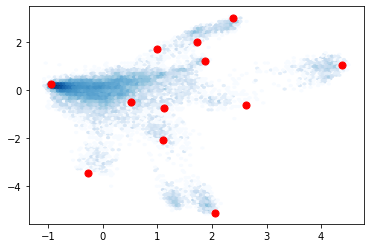

In [198]:
txx = np.concatenate(tica_trajs)
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='Blues')
# sns.displot(x=txx[:,0], y=txx[:,1], log_scale=True)
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1],
            s=50, c='r')

In [112]:
from msmbuilder.msm import MarkovStateModel
msm = MarkovStateModel(lag_time=2, n_timescales=20)
msm.fit(clustered_trajs)

MSM contains 1 strongly connected component above weight=0.50. Component 0 selected, with population 100.000000%


MarkovStateModel(lag_time=2, n_timescales=20)

In [113]:
assignments = clusterer.partial_transform(txx)
assignments = msm.partial_transform(assignments)

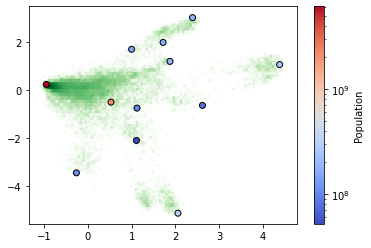

In [211]:
from matplotlib.colors import LogNorm

hb = plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='Greens')

plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            c=1e10 * msm.populations_,       # color by population
            norm=LogNorm(),                  # use a log color scale
            cmap='coolwarm', edgecolors='black')
plt.colorbar(label="Population")